In [35]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

### 1. Simple Brownian Motion trajectories

In [6]:
def create_path_BM(length: float, num_splits: int) -> np.ndarray:
    """
    length: float -- last moment of time to be simulated
    num_splits: int -- number of increments to create, 
    increment is \Delta W_t and it is sample from N(0, T/N)
    
    return trajectory of brownian motion with 
    """
    increments = np.random.normal(loc=0, 
                                  scale=(length/num_splits) ** 0.5, 
                                  size=num_splits)
    
    trajectory = np.zeros(num_splits+1)
    trajectory[1:] = np.cumsum(increments)
    return trajectory

In [68]:
def plot_trajectories(length: float, num_splits: int, num_traj: int, 
                      y_label: str = "$W_t$",
                      process_name: str = "Wiener process",
                      sim_func: Callable = create_path_BM, 
                      **sim_func_kwargs) -> None:
    """
    just a simple plotting function
    """
    
    plt.figure(figsize=(13, 7))
    for traj in range(num_traj):
        plt.plot(np.arange(0, length, length/(num_splits + 1)), 
                 sim_func(length, num_splits, **sim_func_kwargs))
    
    plt.xlabel("$t$")
    plt.ylabel(y_label)
    plt.title(f"Simulated trajectories of a {process_name}")
    plt.xlim(0, length)
    
    plt.show()

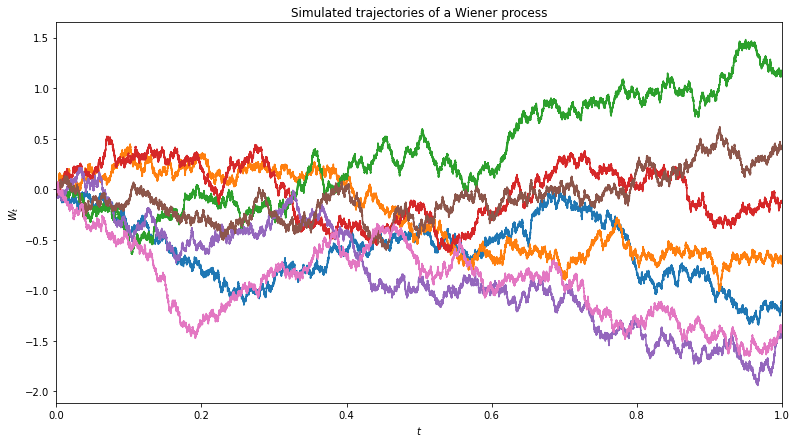

In [45]:
plot_trajectories(1, 100000, 7)

### 1.1 Simple BM with drift

In [70]:
def create_path_BM_drift(length: float, num_splits: int,
                          slope: int = 0, sd: int = 1):
    """
    Same as simple BM trajectories but with a slope and sd parameters
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = slope * np.arange(0, length, length/(num_splits + 1))
    
    trajectory = linear_part + sd * basic_BM_traj
    return trajectory

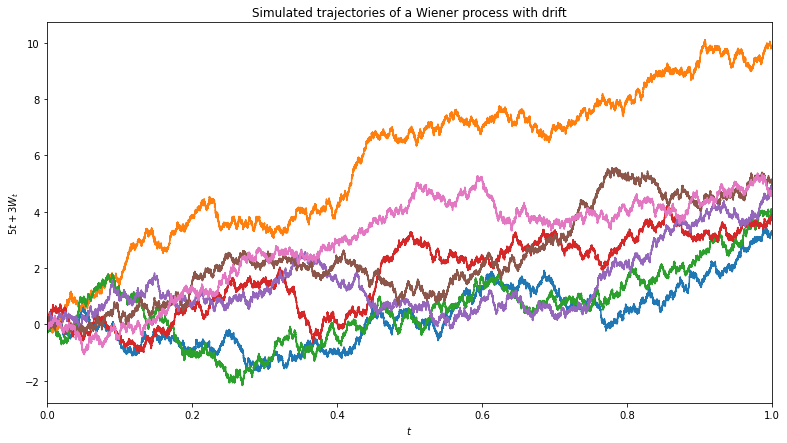

In [71]:
plot_trajectories(1, 100000, 7, f"${5}t + 3 W_t$", 
                  "Wiener process with drift",
                  create_path_BM_drift, slope=5, sd=3)